In [2]:
import h5py
from dspeed import build_dsp
import numpy as np
import matplotlib.pyplot as plt
from iminuit import cost, Minuit
import scipy.special as sp
import multiprocessing as mp

In [ ]:
### A PARALLELIZED VERSION OF THE SI_DSP_OG NOTEBOOK ###
### This version uses the multiprocessing library to parallelize the slow part of the dsp visualization notebook

In [3]:
file = "DataR_CH1@DT5725_1146_run_2.lh5" # path to raw file
#dsp_file = "DataR_CH1@DT5725_1146_run_2_dsp.lh5" # path to output dsp file but we dont need this here

This DSP configuration file will produce the `trapEftp` parameter. You can scroll to the bottom and work your way back to see all the processors we need to generate it.

There are a couple of parameters that can be optimized in order to get the best energy resolution:
<ul>
    <li> pz_tau </li>
    <li> etrap.rise  </li>
    <li> etrap.flat </li>
    <li> ftp </li>
</ul>

We know what `pz_tau` should be from the decay constant measurement, so we don't need to optimize it.

`etrap.flat` just needs to be decently longer than the rise time of the waveform, so don't worry about it too much

`ftp` is set relative to the parameter of the energy trapezoid, to make sure that we're picking from the flat top

That leaves `etrap.flat` to be optimized. You can do this manually, by just typing in different numbers into the cell below. You can also write some code to loop through some numbers and run the DSP. Your optimization condition is when your peak has the best resolution - either minimize the width or maximize the height. 


In [4]:
dsp_config = {
    "outputs": ["bl", "trapEftp"],
    "processors": {
        "bl, bl_sig, bl_slope, bl_intercept": {
            "function": "linear_slope_fit",
            "module": "dspeed.processors",
            "args": ["waveform[:1000]", "bl", "bl_sig", "bl_slope", "bl_intercept"],
            "unit": ["ADC", "ADC", "ADC", "ADC"]
        },
        "wf_blsub": {
                "function": "subtract",
                "module": "numpy",
                "args": ["waveform", "bl", "wf_blsub"],
                "unit": "ADC"
            },
        "wf_pz": {
                "function": "pole_zero",
                "module": "dspeed.processors",
                "args": ["wf_blsub", "db.pz_tau", "wf_pz"],
                "unit": "ADC"
            },
        "wf_etrap": {
                "function": "trap_norm",
                "module": "dspeed.processors",
                "args": ["wf_pz", "db.etrap.rise", "db.etrap.flat", "wf_etrap"],
                "unit": "ADC"
            },
        "trapEftp": {
                "function": "fixed_time_pickoff",
                "module": "dspeed.processors",
                "args": ["wf_etrap", "db.ftp", "'l'", "trapEftp"], 
                "unit": "ADC"
            }
    }    
}

In [5]:
def process_data(rise,flat):
    dsp_db = {
        "CompassEvent": {
            "pz_tau": "0.5*ms",
            "etrap": {
                "rise": f"{rise}*us",
                "flat": f"{flat}*us"
            },
            "ftp": 1000 + (rise + 0.5*flat)/(0.004)
        }
    }
    #potentially put a path here for f_dsp if you want it all in a directory
    build_dsp(
        f_raw=file, 
        f_dsp=f"dsp_outputs/DataR_CH1@DT5725_1146_run_2_dsp_rise_{rise:.2f}_flat_{flat:.2f}.lh5",   
        lh5_tables = f"CompassEvent",
        dsp_config = dsp_config,
        database = dsp_db,
        write_mode = 'r'
    )

def make_iterable(rises, flats):
    iterable = []
    for rise in rises:
        for flat in flats:
            iterable.append((rise,flat))
    return iterable

rises = np.linspace(3.1, 5, 20) # Change this
flats = np.linspace(3.1, 5, 20)
cores = 6

iterable = make_iterable(rises, flats)
print(iterable)
chunk = int(round(len(rises)*len(flats)/cores))
'''
with mp.Pool(processes=cores) as p:
    p.starmap(process_data, iterable, chunksize=chunk)
            
'''

[(3.1, 3.1), (3.1, 3.2), (3.1, 3.3000000000000003), (3.1, 3.4), (3.1, 3.5), (3.1, 3.6), (3.1, 3.7), (3.1, 3.8), (3.1, 3.9), (3.1, 4.0), (3.1, 4.1), (3.1, 4.2), (3.1, 4.3), (3.1, 4.4), (3.1, 4.5), (3.1, 4.6), (3.1, 4.7), (3.1, 4.8), (3.1, 4.9), (3.1, 5.0), (3.2, 3.1), (3.2, 3.2), (3.2, 3.3000000000000003), (3.2, 3.4), (3.2, 3.5), (3.2, 3.6), (3.2, 3.7), (3.2, 3.8), (3.2, 3.9), (3.2, 4.0), (3.2, 4.1), (3.2, 4.2), (3.2, 4.3), (3.2, 4.4), (3.2, 4.5), (3.2, 4.6), (3.2, 4.7), (3.2, 4.8), (3.2, 4.9), (3.2, 5.0), (3.3000000000000003, 3.1), (3.3000000000000003, 3.2), (3.3000000000000003, 3.3000000000000003), (3.3000000000000003, 3.4), (3.3000000000000003, 3.5), (3.3000000000000003, 3.6), (3.3000000000000003, 3.7), (3.3000000000000003, 3.8), (3.3000000000000003, 3.9), (3.3000000000000003, 4.0), (3.3000000000000003, 4.1), (3.3000000000000003, 4.2), (3.3000000000000003, 4.3), (3.3000000000000003, 4.4), (3.3000000000000003, 4.5), (3.3000000000000003, 4.6), (3.3000000000000003, 4.7), (3.300000000000

'\nwith mp.Pool(processes=cores) as p:\n    p.starmap(process_data, iterable, chunksize=chunk)\n            \n'

In [6]:
rises = np.linspace(0.1, 5, 50) # Change this
flats = np.linspace(0.1, 5, 50)

In [12]:
def select_n_cut(dsp_file):
    f = h5py.File(dsp_file)
    trapEftp = f['CompassEvent']['trapEftp']
    noise_cut = trapEftp[:]
    noise_cut = noise_cut[noise_cut > 400]
    return noise_cut


####################################
### Define Global Variables Here ###
####################################

x = np.linspace(0, 700, 701)   #need
bins = x  #need   
_, bin_edges = np.histogram(select_n_cut(f"dsp_outputs/DataR_CH1@DT5725_1146_run_2_dsp_rise_{rises[0]:.2f}_flat_{flats[0]:.2f}.lh5"), bins=bins)  #same for all files so just use first file to generate binedges
binwidth = bin_edges[1] - bin_edges[0]      #need

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2      # sorta need later

#plt.hist(noise_cut, bins=bins, color='blue')



#mean = np.mean(noise_cut) + 6
#std = np.std(noise_cut) - 14
#fwhm = 2.355*std


# Define the fit function 
def fit_func(x, mu, sigma, eta, tau1, tau2):
    #mean = 559.53
    return 0.5 * (((1-eta)/tau1 * np.exp((x-mu)/tau1 + 0.5*(sigma/tau1)**2) * sp.erfc(1/np.sqrt(2)*((x-mu)/sigma + sigma/tau1)))
                  + (eta/tau2 * np.exp((x-mu)/tau2 + 0.5*(sigma/tau2)**2) * sp.erfc(1/np.sqrt(2)*((x-mu)/sigma + sigma/tau2))))

#test_fit = fit_func(x, mean, std, eta=-10, tau1=20, tau2=20)

def cdf_fit_func(x, A, mu, sigma, eta, tau1, tau2):
    return A * np.cumsum(fit_func(x, mu, sigma, eta, tau1, tau2)) * binwidth

def optimizer(counts, gimme_moar=False):
    c = cost.ExtendedBinnedNLL(counts, bin_edges, cdf_fit_func)
    m = Minuit(c, A=10000, mu=559, sigma=15, eta=-10, tau1=20, tau2=20)
    m.limits["A"] = (2000, 10000)
    m.limits["sigma"] = (5,35)
    m.limits["tau1"] = (1, 100)
    m.limits["tau2"] = (1, 100)
    m.limits['eta'] = (0,1)
    var = m.migrad()
    A_fit = m.values['A']
    mean_fit = m.values['mu']
    std_fit = m.values['sigma']
    eta_fit = m.values['eta']
    tau1_fit = m.values['tau1']
    tau2_fit = m.values['tau2']
    fwhm_fit = 2.355*std_fit
    energy_fwhm = fwhm_fit*3271.2/mean_fit
    energy_resolution = fwhm_fit/mean_fit

    minuit_fit = A_fit * fit_func(x, mean_fit, std_fit, eta_fit, tau1_fit, tau2_fit)
    if gimme_moar:
        return minuit_fit, c, A_fit, mean_fit, std_fit, eta_fit, tau1_fit, tau2_fit, fwhm_fit, energy_fwhm, energy_resolution
    else:
        return minuit_fit, mean_fit, fwhm_fit, energy_fwhm, energy_resolution

def plot_fit(noise_cut, minuit_fit, mean_fit, fwhm_fit, energy_fwhm, energy_resolution, rise = False, flat = False):
    #plt.plot(x, test_fit, color='green', label='Test Fit', alpha = 0.75)
    plt.hist(noise_cut, bins=bins, color='blue')
    plt.plot(x, minuit_fit, color='red', label='Minuit Fit', alpha = 0.75)
    #plt.plot(x, cdf_fit, color='green', label='CDF Fit', alpha = 0.75)
    plt.axvline(mean_fit, color='black', linestyle='--', label='Mean: ' + str(round(mean_fit, 2)))
    plt.axvline(mean_fit + fwhm_fit/2, color='black', linestyle=':', label='FWHM: ' + str(round(fwhm_fit, 2)))
    plt.axvline(mean_fit - fwhm_fit/2, color='black', linestyle=':')
    plt.text(0.02, 0.7, 'Energy Resolution: ' + str(round(energy_resolution * 100, 2)) + '%', transform=plt.gca().transAxes)
    plt.text(0.02, 0.75, 'Energy FWHM: ' + str(round(energy_fwhm, 2)), transform=plt.gca().transAxes)
    plt.xlim(350, 650)

    if rise and flat:
        plt.title(f'Gd-148 Alpha Spectrum [Rise: {rise}us, Flat: {flat}us]')
    else:
        plt.title('Gd-148 Alpha Spectrum')
    plt.xlabel('Energy (ADC)')
    plt.ylabel('Counts')
    #plt.ylim(1e-2, 2e2)
    #plt.yscale('log')
    plt.legend()
    plt.show()


def plot_heat_map(e_fwhm_array):
    figgy, axs = plt.subplots(figsize=(10, 10))
    im = axs.imshow(e_fwhm_array, origin='lower')
    axs.set_xticks(np.arange(len(flats)), labels=flats)
    axs.set_yticks(np.arange(len(rises)), labels=rises)
    plt.setp(axs.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
    axs.set_title("E_fwhm vs Rise and Flat Times")
    axs.set_xlabel("Flat Time (us)")
    axs.set_ylabel("Rise Time (us)")
    plt.colorbar(im)
    figgy.tight_layout()
    plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
    plt.show()


20


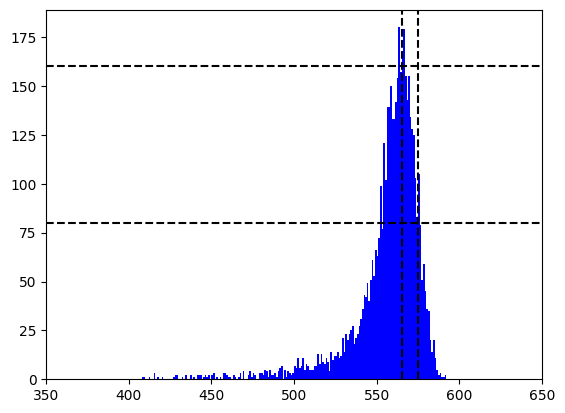

In [67]:
#Testing Block
rise, flat = 3.8, 0.1
dsp_file = f"dsp_outputs/DataR_CH1@DT5725_1146_run_2_dsp_rise_{rise:.2f}_flat_{flat:.2f}.lh5"
noise_cut = select_n_cut(dsp_file)
plt.hist(noise_cut, bins=bins, color='blue')
counts, _ = np.histogram(noise_cut, bins=bins) 
minuit_fit, c, A_fit, mean_fit, std_fit, eta_fit, tau1_fit, tau2_fit, fwhm_fit, energy_fwhm, energy_resolution = optimizer(counts, gimme_moar=True)
#plt.plot(bins, minuit_fit, color='red', label='Minuit Fit', alpha = 0.75)
plt.xlim(350, 650)
plt.axhline(160, color='black', linestyle='--')
plt.axhline(80, color='black', linestyle='--')
plt.axvline(575, color='black', linestyle='--')
plt.axvline(565, color='black', linestyle='--')
fwhm_eye = 20
print(fwhm_eye)
#plt.xlim(400,450)
#plt.ylim(0,10)
#manual_fit = A_fit * fit_func(x, mean_fit, std_fit, eta_fit, tau1_fit, tau2_fit)
#cdf_fit = cdf_fit_func(x, A_fit, mean_fit, std_fit, eta_fit, tau1_fit, tau2_fit)



Rise: 0.1us, Flat: 0.1us
Mean: 584.4674558165151, FWHM: 27.594022779107544, Energy FWHM: 154.44070737679215, Energy Resolution: 0.04721224852555397
Rise: 0.1us, Flat: 0.2us
Mean: 580.1114285394344, FWHM: 28.916289059928314, Energy FWHM: 163.0565441728881, Energy Resolution: 0.049846094452460285
Rise: 0.1us, Flat: 0.30000000000000004us
Mean: 576.8071466546814, FWHM: 30.3643840761828, Energy FWHM: 172.20309035018613, Energy Resolution: 0.05264217728973653
Rise: 0.1us, Flat: 0.4us
Mean: 581.3770439336334, FWHM: 27.41525835749214, Energy FWHM: 154.2558208563627, Energy Resolution: 0.04715572904633245
Rise: 0.1us, Flat: 0.5us
Mean: 573.1241606681291, FWHM: 34.848867196242544, Energy FWHM: 198.90561626202248, Energy Resolution: 0.060805091789564225
Rise: 0.1us, Flat: 0.6us
Mean: 580.2397198753243, FWHM: 30.35689884578531, Energy FWHM: 171.14217469577946, Energy Resolution: 0.052317857268213336
Rise: 0.1us, Flat: 0.7000000000000001us
Mean: 572.7624743285916, FWHM: 36.40323397735566, Energy FW

/tmp/ipykernel_11470/706516572.py:32: RuntimeWarning: overflow encountered in exp
  return 0.5 * (((1-eta)/tau1 * np.exp((x-mu)/tau1 + 0.5*(sigma/tau1)**2) * sp.erfc(1/np.sqrt(2)*((x-mu)/sigma + sigma/tau1)))
/tmp/ipykernel_11470/706516572.py:32: RuntimeWarning: invalid value encountered in multiply
  return 0.5 * (((1-eta)/tau1 * np.exp((x-mu)/tau1 + 0.5*(sigma/tau1)**2) * sp.erfc(1/np.sqrt(2)*((x-mu)/sigma + sigma/tau1)))
/tmp/ipykernel_11470/706516572.py:33: RuntimeWarning: overflow encountered in exp
  + (eta/tau2 * np.exp((x-mu)/tau2 + 0.5*(sigma/tau2)**2) * sp.erfc(1/np.sqrt(2)*((x-mu)/sigma + sigma/tau2))))
/tmp/ipykernel_11470/706516572.py:33: RuntimeWarning: invalid value encountered in multiply
  + (eta/tau2 * np.exp((x-mu)/tau2 + 0.5*(sigma/tau2)**2) * sp.erfc(1/np.sqrt(2)*((x-mu)/sigma + sigma/tau2))))


Rise: 0.1us, Flat: 1.4000000000000001us
Mean: 575.0048039356082, FWHM: 43.35450350199996, Energy FWHM: 246.64359477529527, Energy Resolution: 0.07539850659552925
Rise: 0.1us, Flat: 1.5000000000000002us
Mean: 568.4046307778374, FWHM: 46.12612792452877, Energy FWHM: 265.458410252983, Energy Resolution: 0.08115016209739026
Rise: 0.1us, Flat: 1.6us
Mean: 567.439729268923, FWHM: 48.05806645905395, Energy FWHM: 277.0471274603914, Energy Resolution: 0.08469281225861805
Rise: 0.1us, Flat: 1.7000000000000002us
Mean: 567.494723112577, FWHM: 48.70882875139366, Energy FWHM: 280.77145764040966, Energy Resolution: 0.0858313333456865
Rise: 0.1us, Flat: 1.8000000000000003us
Mean: 566.4736054729541, FWHM: 50.240835111204554, Energy FWHM: 290.1244086713569, Energy Resolution: 0.08869051377823334
Rise: 0.1us, Flat: 1.9000000000000001us
Mean: 566.0962160817862, FWHM: 50.68317639250266, Energy FWHM: 292.87390006366275, Energy Resolution: 0.08953102838825591
Rise: 0.1us, Flat: 2.0us
Mean: 566.0928554519202,

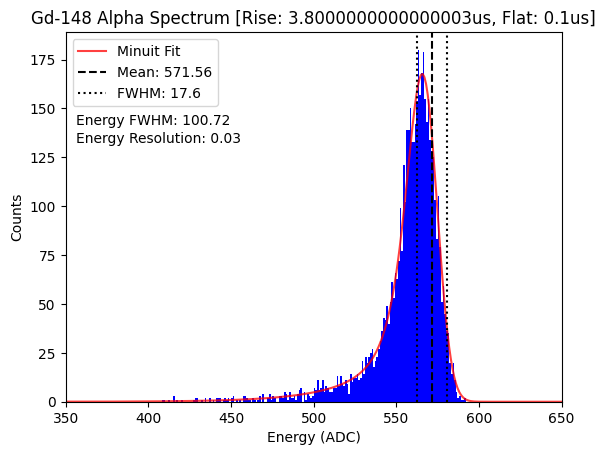

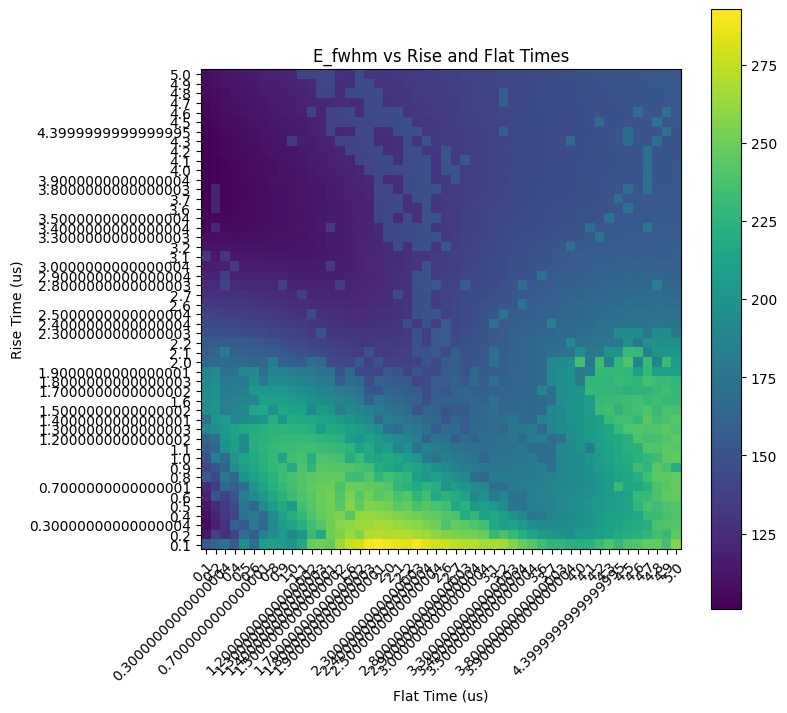

In [9]:
fits = [[None]*len(flats) for _ in range(len(rises))]
e_fwhm_array = np.zeros((len(rises), len(flats)))
#print(np.shape(e_fwhm_array))

#fig, ax = plt.subplots(len(rises), len(flats), figsize=(10,10))

for i, rise in enumerate(rises):
    for j, flat in enumerate(flats):
        input_dsp_file = f"dsp_outputs/DataR_CH1@DT5725_1146_run_2_dsp_rise_{rise:.2f}_flat_{flat:.2f}.lh5"
        noise_cut = select_n_cut(input_dsp_file)
        counts, _ = np.histogram(noise_cut, bins=bins)  #need
        minuit_fit, mean_fit, fwhm_fit, energy_fwhm, energy_resolution = optimizer(counts)
        e_fwhm_array[i][j] = energy_fwhm
        fits[i][j] = minuit_fit
        #plot_data(ax[i,j], noise_cut, minuit_fit, mean_fit, fwhm_fit, energy_fwhm, energy_resolution)
        print(f'Rise: {rise}us, Flat: {flat}us')
        print(f'Mean: {mean_fit}, FWHM: {fwhm_fit}, Energy FWHM: {energy_fwhm}, Energy Resolution: {energy_resolution}')

#print(e_fwhm_array)



37 0
Rise: 3.8000000000000003us, Flat: 0.1us


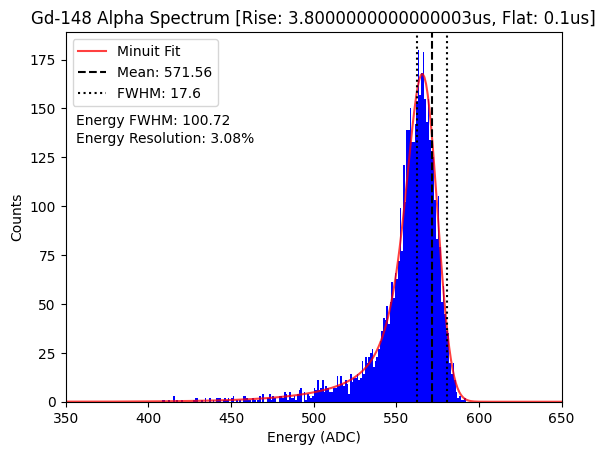

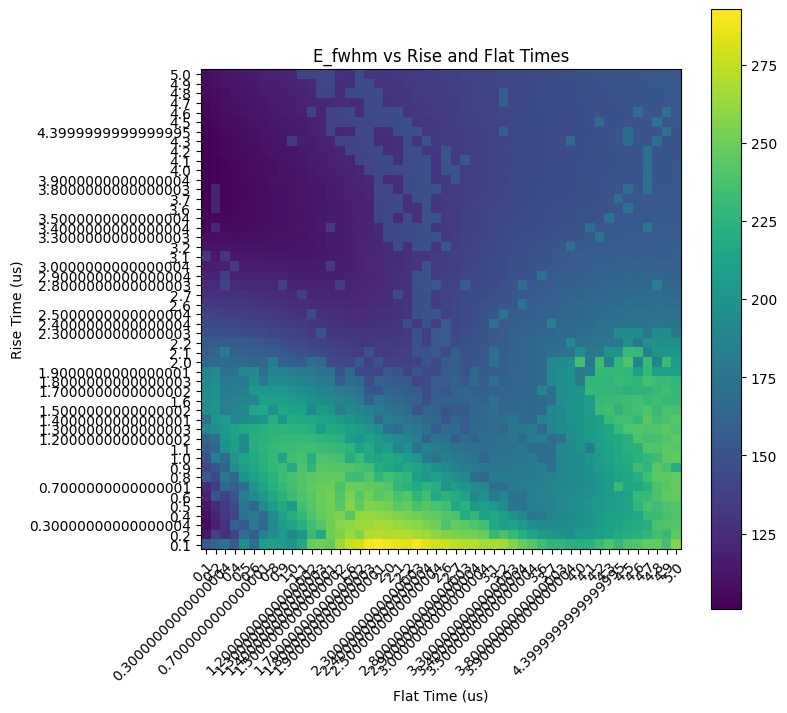

In [13]:
# Find the index of the minimum element
min_index = np.argmin(e_fwhm_array)
row, col = np.unravel_index(min_index, e_fwhm_array.shape)  # Convert the flattened index to row and column indices
print(row,col)
print(f'Rise: {rises[row]}us, Flat: {flats[col]}us')
best_data = select_n_cut(f"dsp_outputs/DataR_CH1@DT5725_1146_run_2_dsp_rise_{rises[row]:.2f}_flat_{flats[col]:.2f}.lh5")
best_counts, _ = np.histogram(best_data, bins=bins)  #need
minuit_fit, c, A_fit, mean_fit, std_fit, eta_fit, tau1_fit, tau2_fit, fwhm_fit, energy_fwhm, energy_resolution = optimizer(best_counts, gimme_moar=True)
plot_fit(best_data, minuit_fit, mean_fit, fwhm_fit, energy_fwhm, energy_resolution, rise = rises[row], flat = flats[col])



plot_heat_map(e_fwhm_array)

In [82]:
print(f"Afit: {A_fit}, mean_fit: {mean_fit}, std_fit: {std_fit}")
print(f"eta_fit: {eta_fit}, tau1_fit: {tau1_fit}, tau2_fit: {tau2_fit}")
print(f"fwhm_fit: {fwhm_fit}, energy_fwhm: {energy_fwhm}, energy_resolution: {energy_resolution}")

Afit: 4830.989022299478, mean_fit: 571.5644838105084, std_fit: 7.472522449696649
eta_fit: 0.6860565187028548, tau1_fit: 29.734802264259518, tau2_fit: 7.689787360395199
fwhm_fit: 17.59779036903561, energy_fwhm: 100.71635569692639, energy_resolution: 0.03078881012989924


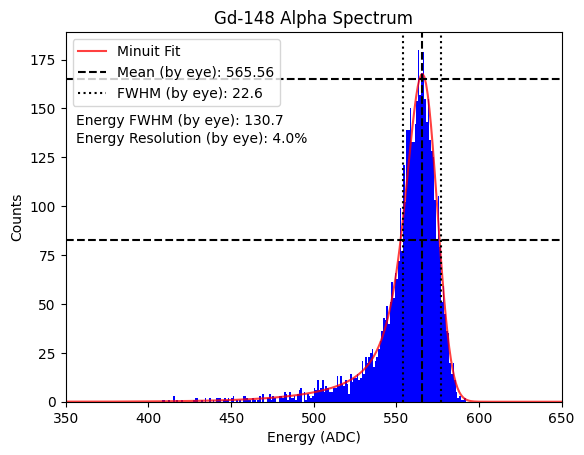

In [14]:
#shift lines by eye

plt.hist(best_data, bins=bins, color='blue')
plt.plot(x, minuit_fit, color='red', label='Minuit Fit', alpha = 0.75)
#plt.plot(x, cdf_fit, color='green', label='CDF Fit', alpha = 0.75)
mean_fit_shift = mean_fit - 6
fwhm_fit_shift = fwhm_fit + 5
e_res = fwhm_fit/mean_fit
e_fwhm = e_res*3271.2
energy_resolution_shift = fwhm_fit_shift/mean_fit_shift
energy_fwhm_shift = fwhm_fit_shift*3271.2/mean_fit_shift

plt.axvline(mean_fit_shift, color='black', linestyle='--', label='Mean (by eye): ' + str(round(mean_fit_shift, 2)))
plt.axvline(mean_fit_shift + fwhm_fit_shift/2, color='black', linestyle=':', label='FWHM (by eye): ' + str(round(fwhm_fit_shift, 2)))
plt.axvline(mean_fit_shift - fwhm_fit_shift/2, color='black', linestyle=':')
plt.text(0.02, 0.7, 'Energy Resolution (by eye): ' + str(round(energy_resolution_shift * 100, 2)) + '%', transform=plt.gca().transAxes)
plt.text(0.02, 0.75, 'Energy FWHM (by eye): ' + str(round(energy_fwhm_shift, 2)), transform=plt.gca().transAxes)

plt.xlim(350, 650)

plt.axhline(165, color='black', linestyle='--')
plt.axhline(82.5, color='black', linestyle='--')

plt.title('Gd-148 Alpha Spectrum')
plt.xlabel('Energy (ADC)')
plt.ylabel('Counts')
#plt.ylim(1e-2, 2e2)
#plt.yscale('log')
plt.legend()
plt.show()

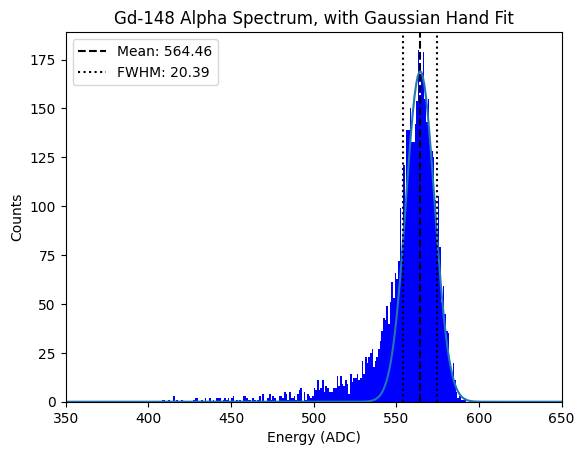

In [25]:
def gaussian(x, A_f, meany, stdy):
    return A_f * np.exp(-1. * ((x-meany)**2.)/(2.* stdy**2))

best_data2 = best_data[best_data < 600]
A_final = np.max(best_counts) -11
mean_final = np.mean(best_data2) + 8
std_final = np.std(best_data2) - 13
fwhm_final = 2.355*std_final

final_gauss = gaussian(x, A_final, mean_final, std_final)
plt.hist(best_data2, bins=bins, color='blue')
plt.plot(final_gauss)
plt.axvline(mean_final, color='black', linestyle='--', label='Mean: ' + str(round(mean_final, 2)))
plt.axvline(mean_final + fwhm_final/2, color='black', linestyle=':', label='FWHM: ' + str(round(fwhm_final, 2)))
plt.axvline(mean_final - fwhm_final/2, color='black', linestyle=':')
plt.xlabel('Energy (ADC)')
plt.ylabel('Counts')
plt.title('Gd-148 Alpha Spectrum, with Gaussian Hand Fit')
plt.xlim(350, 650)
plt.legend()


(350.0, 650.0)

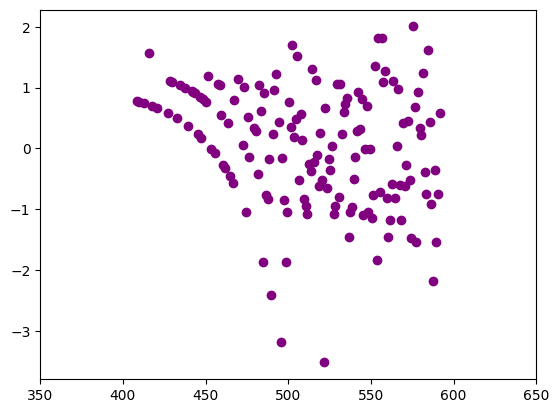

In [10]:
params = [A_fit, mean_fit, std_fit, eta_fit, tau1_fit, tau2_fit]
residuals = c.pulls(params)

plt.scatter(bin_centers, residuals, color='purple', label='Residuals')
plt.xlim(350, 650)

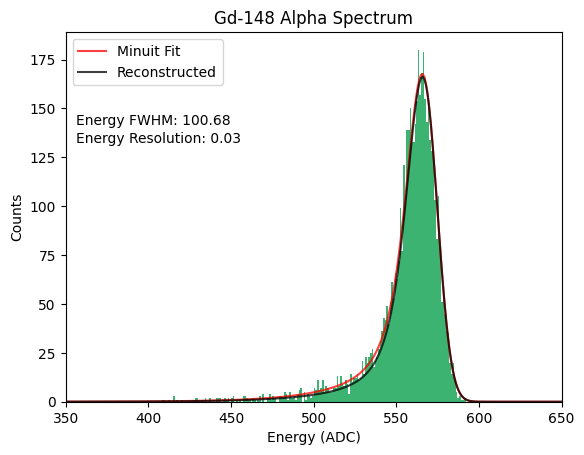

In [11]:
def term1(x, A, mu, sigma, eta, tau1):
    return A * 0.5 * ((1-eta)/tau1 * np.exp((x-mu)/tau1 + 0.5*(sigma/tau1)**2) * sp.erfc(1/np.sqrt(2)*((x-mu)/sigma + sigma/tau1)))
    
def term2(x, A, mu, sigma, eta, tau2):
    return A * 0.5 * (eta/tau2 * np.exp((x-mu)/tau2 + 0.5*(sigma/tau2)**2) * sp.erfc(1/np.sqrt(2)*((x-mu)/sigma + sigma/tau2)))

eta_mod = eta_fit + 0.07
tau1_mod = tau1_fit + 1
tau2_mod = tau2_fit + 1
test_term1 = term1(x, A_fit, mean_fit, std_fit, eta_mod, tau1_fit)
test_term1a = term1(x, A_fit, mean_fit, std_fit, eta_fit, tau1_mod)
test_term2 = term2(x, A_fit, mean_fit, std_fit, eta_mod, tau2_fit)
test_term2a = term2(x, A_fit, mean_fit, std_fit, eta_fit, tau2_mod)
reconstructed = 0.95 * (test_term1 + test_term2)

plt.hist(best_data, bins=bins, color='mediumseagreen')
plt.plot(x, minuit_fit, color='red', label='Minuit Fit', alpha = 0.75)
#plt.plot(x, test_term1, color='green', label='Term 1', alpha = 0.75)
#plt.plot(x, test_term1a, color='orange', label='Term 1 tau mod', alpha = 0.75)
#plt.plot(x, test_term2, color='purple', label='Term 2', alpha = 0.75) 
plt.plot(x, reconstructed, color='black', label='Reconstructed', alpha = 0.75)
#plt.plot(x, cdf_fit, color='green', label='CDF Fit', alpha = 0.75)
#plt.axvline(mean_fit, color='black', linestyle='--', label='Mean: ' + str(round(mean_fit, 2)))
#plt.axvline(mean_fit + fwhm_fit/2, color='black', linestyle=':', label='FWHM: ' + str(round(fwhm_fit, 2)))
#plt.axvline(mean_fit - fwhm_fit/2, color='black', linestyle=':')
plt.text(0.02, 0.7, 'Energy Resolution: ' + str(round(energy_resolution, 2)), transform=plt.gca().transAxes)
plt.text(0.02, 0.75, 'Energy FWHM: ' + str(round(energy_fwhm, 2)), transform=plt.gca().transAxes)
plt.xlim(350, 650)
plt.title('Gd-148 Alpha Spectrum')
plt.xlabel('Energy (ADC)')
plt.ylabel('Counts')
#plt.ylim(1e-2, 2e2)
#plt.yscale('log')
plt.legend()


I included `wf_blsub`, `wf_pz`, and `wf_etrap` in the output - normally we wouldn't save these since they take up a lot of space. You only have one file though, and it can be instructive to see what the actual output of the pole zero or trapezoidal filter looks like, and how it varies when you change the parameters. Below is some code to help you visualize it.

In [12]:
dsp_config2 = {
    "outputs": ["bl", "trapEftp", "wf_pz", "wf_blsub", "wf_etrap"],
    "processors": {
        "bl, bl_sig, bl_slope, bl_intercept": {
            "function": "linear_slope_fit",
            "module": "dspeed.processors",
            "args": ["waveform[:1000]", "bl", "bl_sig", "bl_slope", "bl_intercept"],
            "unit": ["ADC", "ADC", "ADC", "ADC"]
        },
        "wf_blsub": {
                "function": "subtract",
                "module": "numpy",
                "args": ["waveform", "bl", "wf_blsub"],
                "unit": "ADC"
            },
        "wf_pz": {
                "function": "pole_zero",
                "module": "dspeed.processors",
                "args": ["wf_blsub", "db.pz_tau", "wf_pz"],
                "unit": "ADC"
            },
        "wf_etrap": {
                "function": "trap_norm",
                "module": "dspeed.processors",
                "args": ["wf_pz", "db.etrap.rise", "db.etrap.flat", "wf_etrap"],
                "unit": "ADC"
            },
        "trapEftp": {
                "function": "fixed_time_pickoff",
                "module": "dspeed.processors",
                "args": ["wf_etrap", "db.ftp", "'l'", "trapEftp"], 
                "unit": "ADC"
            }
    }    
}

In [13]:
rise = rises[row]
flat = flats[col]
output_path = f"dsp_outputs_with_wfs/DataR_CH1@DT5725_1146_run_2_dsp_rise_{rise:.2f}_flat_{flat:.2f}.lh5"


dsp_db2 = {
    "CompassEvent": {
        "pz_tau": "0.5*ms",
        "etrap": {
            "rise": f"{rise}*us",
            "flat": f"{flat}*us"
        },
        "ftp": 1000 + (rise + 0.5*flat)/(0.004)
    }
}
#potentially put a path here for f_dsp if you want it all in a directory
build_dsp(
    f_raw=file, 
    f_dsp=output_path,   
    lh5_tables = f"CompassEvent",
    dsp_config = dsp_config2,
    database = dsp_db2,
    write_mode = 'r'
)

f = h5py.File(output_path)

Processing table CompassEvent:  63%|######3   | 3200/5066 [00:08<00:04, 373.21 rows/s]

In [14]:
wf_blsub = f['CompassEvent']['wf_blsub']['values']
wf_pz = f['CompassEvent']['wf_pz']['values']
wf_etrap = f['CompassEvent']['wf_etrap']['values']

super_wf_blsub = np.average(wf_blsub/np.max(wf_blsub, axis=1)[:,None], axis=0)
super_wf_pz = np.average(wf_pz/np.max(wf_pz, axis=1)[:,None], axis=0)
super_wf_etrap = np.average(wf_etrap/np.max(wf_etrap, axis=1)[:,None], axis=0)

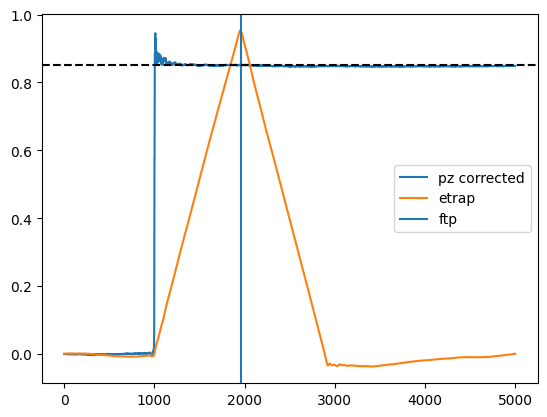

In [15]:
#plt.figure(figsize=(12,10))
#plt.plot(super_wf_blsub, label="original");
plt.plot(super_wf_pz, label="pz corrected");
plt.plot(super_wf_etrap, label="etrap");
plt.axvline(dsp_db2["CompassEvent"]["ftp"], label="ftp");
plt.axhline(0.85, color='black', linestyle='--')
plt.legend()
#plt.xlim(980, 1025)